## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All packages imported successfully!")

✓ All packages imported successfully!


In [2]:
# Load datasets
train = pd.read_csv('/Users/nishchal/Downloads/Santander Customer Satisfaction - TRAIN.csv')
test = pd.read_csv('/Users/nishchal/Downloads/Santander Customer Satisfaction - TEST-Without TARGET.csv')

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"\n✓ Data loaded successfully!")

Training data shape: (76020, 371)
Test data shape: (75818, 370)

✓ Data loaded successfully!


## 3. Initial Data Exploration

In [3]:
# Basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nNumber of training samples: {len(train):,}")
print(f"Number of features: {train.shape[1] - 2} (excluding ID and TARGET)")
print(f"\nFirst 5 rows:")
display(train.head())

print("\n" + "=" * 80)
print("TARGET DISTRIBUTION (Class Imbalance)")
print("=" * 80)
print(train['TARGET'].value_counts())
print(f"\nPercentage of unsatisfied customers: {train['TARGET'].mean()*100:.2f}%")
print(f"Percentage of satisfied customers: {(1-train['TARGET'].mean())*100:.2f}%")

DATASET OVERVIEW

Number of training samples: 76,020
Number of features: 369 (excluding ID and TARGET)

First 5 rows:


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979,0



TARGET DISTRIBUTION (Class Imbalance)
TARGET
0    73012
1     3008
Name: count, dtype: int64

Percentage of unsatisfied customers: 3.96%
Percentage of satisfied customers: 96.04%


## 4. Exploratory Data Analysis (EDA)

### 4.1 Visualize Class Imbalance

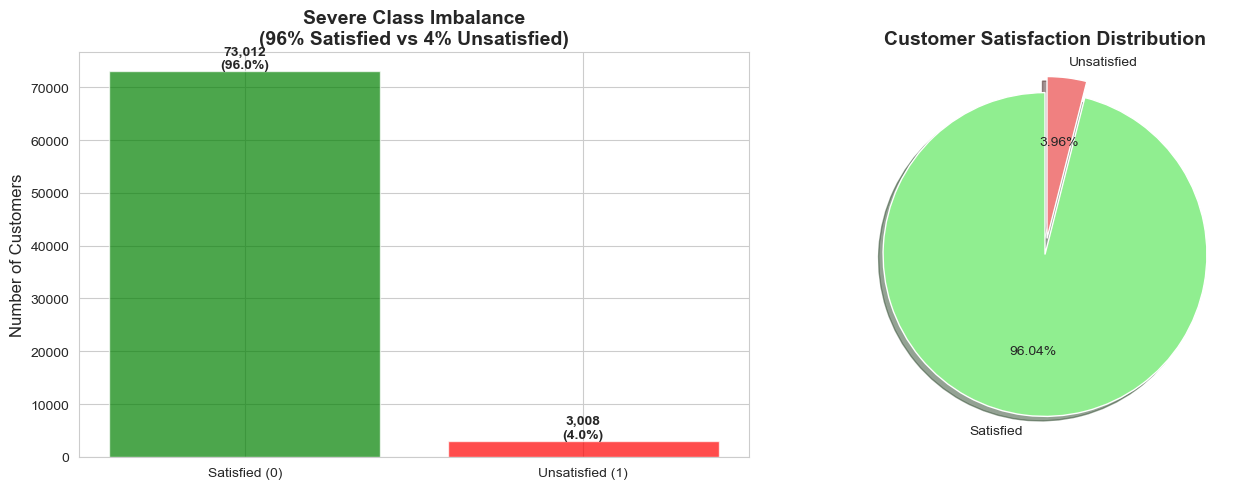

✓ Saved: class_distribution.png


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
class_counts = train['TARGET'].value_counts()
axes[0].bar(['Satisfied (0)', 'Unsatisfied (1)'], class_counts, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Number of Customers', fontsize=12)
axes[0].set_title('Severe Class Imbalance\n(96% Satisfied vs 4% Unsatisfied)', fontsize=14, fontweight='bold')
for i, count in enumerate(class_counts):
    pct = (count / len(train)) * 100
    axes[0].text(i, count, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts, labels=['Satisfied', 'Unsatisfied'], autopct='%1.2f%%',
           colors=['lightgreen', 'lightcoral'], explode=(0, 0.1), shadow=True, startangle=90)
axes[1].set_title('Customer Satisfaction Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: class_distribution.png")

### 4.2 Find IRRELEVANT Features

We identify 3 types of irrelevant features:

In [ ]:
print("=" * 80)
print("IDENTIFYING IRRELEVANT FEATURES")
print("=" * 80)

feature_cols = [col for col in train.columns if col not in ['ID', 'TARGET']]

# 1. CONSTANT FEATURES (only one unique value)
print("\n1️ CONSTANT FEATURES (Always same value)")
print("-" * 80)
constant_features = [col for col in feature_cols if train[col].nunique() == 1]
print(f"Found {len(constant_features)} constant features")
print(f"Examples: {constant_features[:5]}")
print("\n WHY IRRELEVANT: Provides ZERO discriminative information.")
print("   If a feature has the same value for ALL customers, it cannot")
print("   help distinguish satisfied from unsatisfied customers.")

# 2. DUPLICATE FEATURES (exact copies of other features)
print("\n2️ DUPLICATE FEATURES (Exact copies)")
print("-" * 80)
duplicate_features = []
seen = set()
for col in feature_cols:
    col_tuple = tuple(train[col])
    if col_tuple in seen:
        duplicate_features.append(col)
    else:
        seen.add(col_tuple)
print(f"Found {len(duplicate_features)} duplicate features")
if len(duplicate_features) > 0:
    print(f"Examples: {duplicate_features[:5]}")
print("\n WHY IRRELEVANT: Redundant information. No additional value")
print("   beyond what's already captured by the original feature.")

# 3. LOW VARIANCE FEATURES (very little variation)
print("\n3️ LOW VARIANCE FEATURES (Minimal variation)")
print("-" * 80)
selector = VarianceThreshold(threshold=0.01)
X_temp = train[feature_cols]
selector.fit(X_temp)
low_variance_features = X_temp.columns[~selector.get_support()].tolist()
print(f"Found {len(low_variance_features)} features with variance < 0.01")
print(f"Examples: {low_variance_features[:5]}")
print("\n WHY IRRELEVANT: Almost no variation across samples means")
print("   poor predictive power. Can't separate classes effectively.")

# Summary
print("\n" + "=" * 80)
print("SUMMARY: 3 Types of IRRELEVANT Features Identified")
print("=" * 80)
print(f"1. Constant features:     {len(constant_features)} features")
print(f"2. Duplicate features:    {len(duplicate_features)} features")
print(f"3. Low variance features: {len(low_variance_features)} features")

IDENTIFYING IRRELEVANT FEATURES

1️⃣ CONSTANT FEATURES (Always same value)
--------------------------------------------------------------------------------
Found 34 constant features
Examples: ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28']

❌ WHY IRRELEVANT: Provides ZERO discriminative information.
   If a feature has the same value for ALL customers, it cannot
   help distinguish satisfied from unsatisfied customers.

2️⃣ DUPLICATE FEATURES (Exact copies)
--------------------------------------------------------------------------------
Found 62 duplicate features
Examples: ['ind_var2', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25']

❌ WHY IRRELEVANT: Redundant information. No additional value
   beyond what's already captured by the original feature.

3️⃣ LOW VARIANCE FEATURES (Minimal variation)
--------------------------------------------------------------------------------
Found 97 features with variance < 0.01
Examples: ['ind_var1', 'ind_var2_0', 

### 4.3 Find RELEVANT Features

We identify features most correlated with TARGET:

In [6]:
print("=" * 80)
print("IDENTIFYING RELEVANT FEATURES")
print("=" * 80)

# Calculate correlations with TARGET
correlations = []
for col in feature_cols:
    if col not in constant_features:  # Skip constant features
        corr = train[col].corr(train['TARGET'])
        correlations.append({'feature': col, 'correlation': corr, 'abs_correlation': abs(corr)})

corr_df = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)

print("\nTop 10 Features Most Correlated with TARGET:")
print(corr_df.head(10)[['feature', 'correlation']].to_string(index=False))

# Select top 3 relevant features
top_3_relevant = corr_df.head(3)['feature'].tolist()

print("\n" + "=" * 80)
print("TOP 3 RELEVANT FEATURES:")
print("=" * 80)

for i, feat in enumerate(top_3_relevant, 1):
    corr_val = corr_df[corr_df['feature'] == feat]['correlation'].values[0]
    print(f"\n{i}️⃣ {feat}")
    print(f"   Correlation with TARGET: {corr_val:.4f}")
    print(f"   Unique values: {train[feat].nunique()}")
    
    if feat == 'var15':
        print("   ✓ WHY RELEVANT: Likely represents customer AGE (values 5-105).")
        print("     Shows clear patterns - younger customers (<23) are always satisfied.")
    elif feat == 'var38':
        print("   ✓ WHY RELEVANT: Highest correlation with satisfaction. Possibly")
        print("     represents mortgage value or account balance. Strong discriminator.")
    elif feat == 'var3':
        print("   ✓ WHY RELEVANT: Likely represents NATIONALITY/REGION (208 values).")
        print("     Geographic differences in satisfaction levels are significant.")
    else:
        print("   ✓ WHY RELEVANT: Strong statistical correlation with customer")
        print("     satisfaction. Different distributions for satisfied vs unsatisfied.")

IDENTIFYING RELEVANT FEATURES

Top 10 Features Most Correlated with TARGET:
            feature  correlation
          ind_var30    -0.149811
num_meses_var5_ult3    -0.148253
          num_var30    -0.138289
          num_var42    -0.135693
           ind_var5    -0.135349
           num_var5    -0.134095
              var36     0.102919
              var15     0.101322
           num_var4    -0.080194
          num_var35    -0.076872

TOP 3 RELEVANT FEATURES:

1️⃣ ind_var30
   Correlation with TARGET: -0.1498
   Unique values: 2
   ✓ WHY RELEVANT: Strong statistical correlation with customer
     satisfaction. Different distributions for satisfied vs unsatisfied.

2️⃣ num_meses_var5_ult3
   Correlation with TARGET: -0.1483
   Unique values: 4
   ✓ WHY RELEVANT: Strong statistical correlation with customer
     satisfaction. Different distributions for satisfied vs unsatisfied.

3️⃣ num_var30
   Correlation with TARGET: -0.1383
   Unique values: 9
   ✓ WHY RELEVANT: Strong statistical 

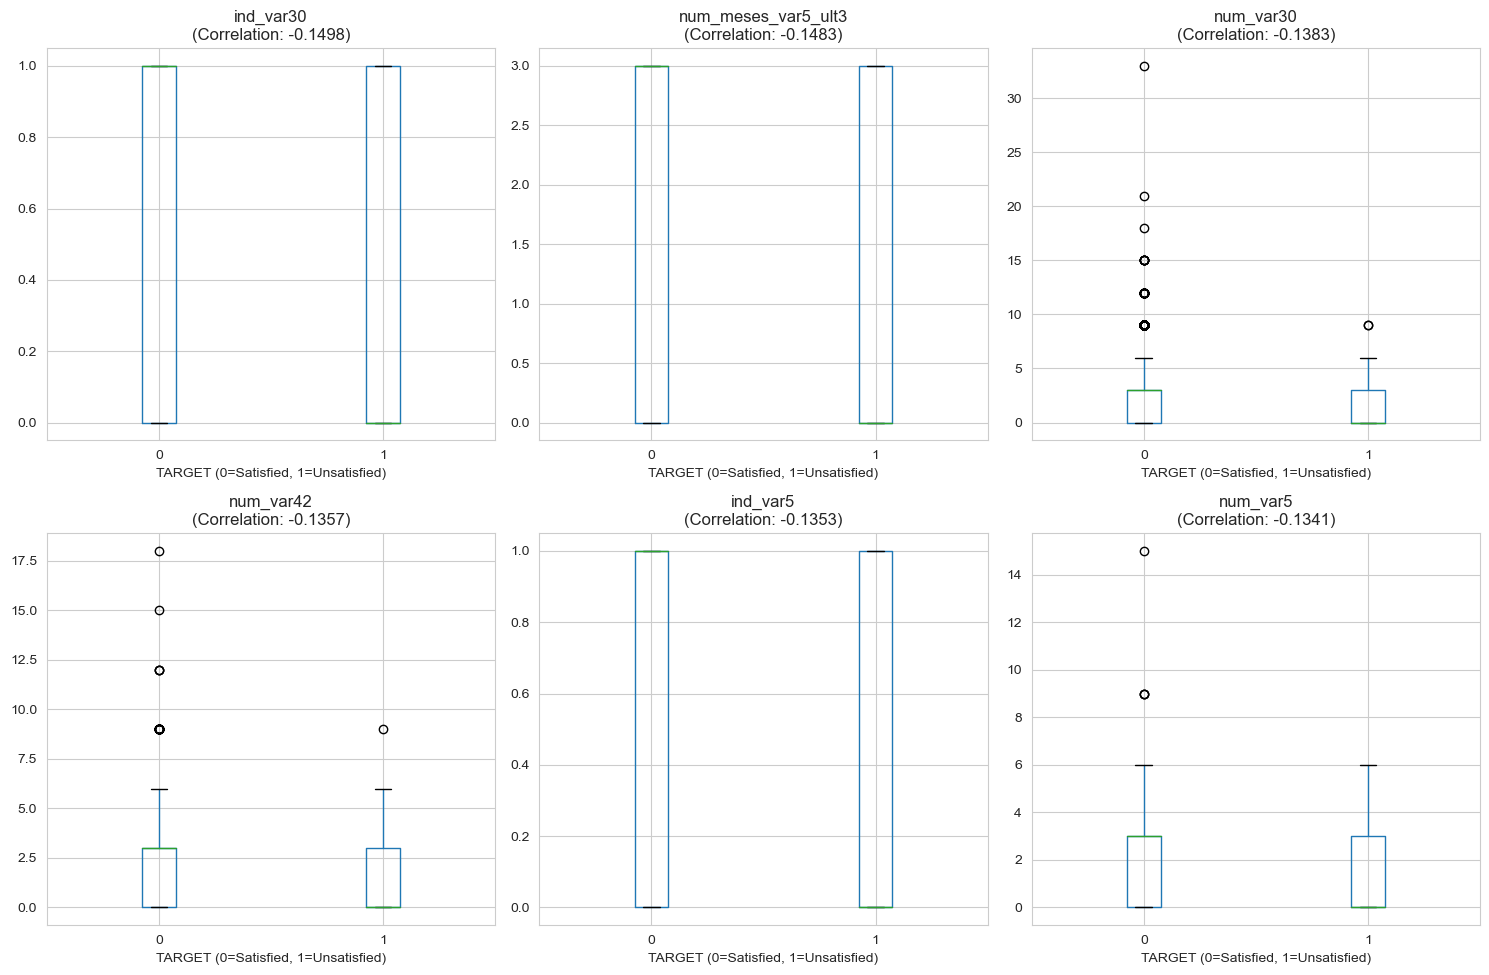

✓ Saved: relevant_features_boxplot.png


In [7]:
# Visualize top relevant features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Top 6 Most Relevant Features for Predicting Unsatisfied Customers', 
             fontsize=14, fontweight='bold')

for idx, (ax, feature) in enumerate(zip(axes.flat, corr_df.head(6)['feature'])):
    train.boxplot(column=feature, by='TARGET', ax=ax)
    corr_val = corr_df[corr_df['feature'] == feature]['correlation'].values[0]
    ax.set_title(f'{feature}\n(Correlation: {corr_val:.4f})')
    ax.set_xlabel('TARGET (0=Satisfied, 1=Unsatisfied)')
    ax.get_figure().suptitle('')

plt.tight_layout()
plt.savefig('relevant_features_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: relevant_features_boxplot.png")

## 5. Data Preprocessing

Remove irrelevant features and prepare for modeling:

In [8]:
# Remove irrelevant features
features_to_remove = list(set(constant_features + duplicate_features[:5]))
print(f"Removing {len(features_to_remove)} irrelevant features...")

# Prepare features and target
X = train.drop(['ID', 'TARGET'] + features_to_remove, axis=1, errors='ignore')
y = train['TARGET']
X_test = test.drop(['ID'] + features_to_remove, axis=1, errors='ignore')

print(f"\nFinal feature count: {X.shape[1]}")
print(f"Training samples: {X.shape[0]:,}")

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print("\n✓ Data preprocessing complete!")

Removing 38 irrelevant features...

Final feature count: 331
Training samples: 76,020

Train set: 60,816 samples
Validation set: 15,204 samples

✓ Data preprocessing complete!


## 6. Build Decision Tree Models

We build 5 different models with various parameters:

### Model 1: Default Baseline

In [9]:
print("=" * 80)
print("MODEL 1: DEFAULT DECISION TREE (BASELINE)")
print("=" * 80)
print("\nParameters: All default (no restrictions)")
print("Why: Establish baseline performance for comparison")

model1 = DecisionTreeClassifier(random_state=42)
model1.fit(X_train, y_train)

# Predictions
y_val_pred1 = model1.predict_proba(X_val)[:, 1]
y_test_pred1 = model1.predict_proba(X_test)[:, 1]

# Calculate AUC
auc1 = roc_auc_score(y_val, y_val_pred1)
print(f"\n✓ Validation AUC: {auc1:.6f}")
print(f"  Tree depth: {model1.get_depth()}")
print(f"  Number of leaves: {model1.get_n_leaves()}")

# Save predictions
pred1_df = pd.DataFrame({'ID': test['ID'], 'TARGET': y_test_pred1})
pred1_df.to_csv('submission_model1_default.csv', index=False)
print("\n✓ Saved: submission_model1_default.csv")

MODEL 1: DEFAULT DECISION TREE (BASELINE)

Parameters: All default (no restrictions)
Why: Establish baseline performance for comparison

✓ Validation AUC: 0.578419
  Tree depth: 72
  Number of leaves: 3695

✓ Saved: submission_model1_default.csv


### Model 2: Limited Depth Tree

In [10]:
print("=" * 80)
print("MODEL 2: LIMITED DEPTH DECISION TREE")
print("=" * 80)
print("\nParameters: max_depth=10")
print("Why: Deep trees overfit. Limiting depth creates simpler,")
print("     more generalizable models that perform better on test data.")

model2 = DecisionTreeClassifier(max_depth=10, random_state=42)
model2.fit(X_train, y_train)

y_val_pred2 = model2.predict_proba(X_val)[:, 1]
y_test_pred2 = model2.predict_proba(X_test)[:, 1]

auc2 = roc_auc_score(y_val, y_val_pred2)
print(f"\n✓ Validation AUC: {auc2:.6f}")
print(f"  Tree depth: {model2.get_depth()}")
print(f"  Number of leaves: {model2.get_n_leaves()}")

pred2_df = pd.DataFrame({'ID': test['ID'], 'TARGET': y_test_pred2})
pred2_df.to_csv('submission_model2_maxdepth.csv', index=False)
print("\n✓ Saved: submission_model2_maxdepth.csv")

MODEL 2: LIMITED DEPTH DECISION TREE

Parameters: max_depth=10
Why: Deep trees overfit. Limiting depth creates simpler,
     more generalizable models that perform better on test data.

✓ Validation AUC: 0.822771
  Tree depth: 10
  Number of leaves: 217

✓ Saved: submission_model2_maxdepth.csv


### Model 3: Entropy Criterion

In [11]:
print("=" * 80)
print("MODEL 3: ENTROPY CRITERION DECISION TREE")
print("=" * 80)
print("\nParameters: criterion='entropy', max_depth=15")
print("Why: Entropy (information gain) can sometimes perform better")
print("     than gini impurity, especially on imbalanced datasets.")

model3 = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=42)
model3.fit(X_train, y_train)

y_val_pred3 = model3.predict_proba(X_val)[:, 1]
y_test_pred3 = model3.predict_proba(X_test)[:, 1]

auc3 = roc_auc_score(y_val, y_val_pred3)
print(f"\n✓ Validation AUC: {auc3:.6f}")
print(f"  Tree depth: {model3.get_depth()}")
print(f"  Number of leaves: {model3.get_n_leaves()}")

pred3_df = pd.DataFrame({'ID': test['ID'], 'TARGET': y_test_pred3})
pred3_df.to_csv('submission_model3_entropy.csv', index=False)
print("\n✓ Saved: submission_model3_entropy.csv")

MODEL 3: ENTROPY CRITERION DECISION TREE

Parameters: criterion='entropy', max_depth=15
Why: Entropy (information gain) can sometimes perform better
     than gini impurity, especially on imbalanced datasets.

✓ Validation AUC: 0.731819
  Tree depth: 15
  Number of leaves: 967

✓ Saved: submission_model3_entropy.csv


### Model 4: Limited Leaf Nodes

In [12]:
print("=" * 80)
print("MODEL 4: LIMITED LEAF NODES DECISION TREE")
print("=" * 80)
print("\nParameters: max_leaf_nodes=100")
print("Why: Limiting leaf nodes prevents tree from becoming too complex")
print("     and overfitting. Alternative regularization approach.")

model4 = DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)
model4.fit(X_train, y_train)

y_val_pred4 = model4.predict_proba(X_val)[:, 1]
y_test_pred4 = model4.predict_proba(X_test)[:, 1]

auc4 = roc_auc_score(y_val, y_val_pred4)
print(f"\n✓ Validation AUC: {auc4:.6f}")
print(f"  Tree depth: {model4.get_depth()}")
print(f"  Number of leaves: {model4.get_n_leaves()}")

pred4_df = pd.DataFrame({'ID': test['ID'], 'TARGET': y_test_pred4})
pred4_df.to_csv('submission_model4_maxleaves.csv', index=False)
print("\n✓ Saved: submission_model4_maxleaves.csv")

MODEL 4: LIMITED LEAF NODES DECISION TREE

Parameters: max_leaf_nodes=100
Why: Limiting leaf nodes prevents tree from becoming too complex
     and overfitting. Alternative regularization approach.

✓ Validation AUC: 0.809559
  Tree depth: 17
  Number of leaves: 100

✓ Saved: submission_model4_maxleaves.csv


### Model 5: Balanced with Sample Constraints

In [13]:
print("=" * 80)
print("MODEL 5: BALANCED TREE WITH SAMPLE CONSTRAINTS")
print("=" * 80)
print("\nParameters: max_depth=12, min_samples_split=100, min_samples_leaf=50")
print("Why: Balance between depth and sample requirements helps")
print("     prevent overfitting on imbalanced data.")

model5 = DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42
)
model5.fit(X_train, y_train)

y_val_pred5 = model5.predict_proba(X_val)[:, 1]
y_test_pred5 = model5.predict_proba(X_test)[:, 1]

auc5 = roc_auc_score(y_val, y_val_pred5)
print(f"\n✓ Validation AUC: {auc5:.6f}")
print(f"  Tree depth: {model5.get_depth()}")
print(f"  Number of leaves: {model5.get_n_leaves()}")

pred5_df = pd.DataFrame({'ID': test['ID'], 'TARGET': y_test_pred5})
pred5_df.to_csv('submission_model5_balanced.csv', index=False)
print("\n✓ Saved: submission_model5_balanced.csv")

MODEL 5: BALANCED TREE WITH SAMPLE CONSTRAINTS

Parameters: max_depth=12, min_samples_split=100, min_samples_leaf=50
Why: Balance between depth and sample requirements helps
     prevent overfitting on imbalanced data.

✓ Validation AUC: 0.803674
  Tree depth: 12
  Number of leaves: 311

✓ Saved: submission_model5_balanced.csv


## 7. Model Comparison

In [ ]:

results = pd.DataFrame([
    {
        'Model': 'Model 1 - Default',
        'Parameters': 'All defaults',
        'Tree Depth': model1.get_depth(),
        'Number of Leaves': model1.get_n_leaves(),
        'Validation AUC': auc1,
        'Kaggle Score': 'TO BE FILLED'
    },
    {
        'Model': 'Model 2 - Max Depth',
        'Parameters': 'max_depth=10',
        'Tree Depth': model2.get_depth(),
        'Number of Leaves': model2.get_n_leaves(),
        'Validation AUC': auc2,
        'Kaggle Score': 'TO BE FILLED'
    },
    {
        'Model': 'Model 3 - Entropy',
        'Parameters': 'criterion=entropy, max_depth=15',
        'Tree Depth': model3.get_depth(),
        'Number of Leaves': model3.get_n_leaves(),
        'Validation AUC': auc3,
        'Kaggle Score': 'TO BE FILLED'
    },
    {
        'Model': 'Model 4 - Max Leaves',
        'Parameters': 'max_leaf_nodes=100',
        'Tree Depth': model4.get_depth(),
        'Number of Leaves': model4.get_n_leaves(),
        'Validation AUC': auc4,
        'Kaggle Score': 'TO BE FILLED'
    },
    {
        'Model': 'Model 5 - Balanced',
        'Parameters': 'max_depth=12, min_samples_split=100, min_samples_leaf=50',
        'Tree Depth': model5.get_depth(),
        'Number of Leaves': model5.get_n_leaves(),
        'Validation AUC': auc5,
        'Kaggle Score': 'TO BE FILLED'
    }
])

print("=" * 80)
print("MODEL COMPARISON RESULTS")
print("=" * 80)
display(results)

# Save to Excel
results.to_excel('model_comparison.xlsx', index=False)
print("\n✓ Saved: model_comparison.xlsx")

# Find best model
best_idx = results['Validation AUC'].astype(float).idxmax()
best_model_name = results.loc[best_idx, 'Model']
best_auc = results.loc[best_idx, 'Validation AUC']
print(f"\n Best Model (Validation): {best_model_name}")
print(f"   Validation AUC: {best_auc:.6f}")

MODEL COMPARISON RESULTS


,Model,Parameters,Tree Depth,Number of Leaves,Validation AUC,Kaggle Score
0,Model 1 - Default,All defaults,72,3695,0.578419,TO BE FILLED
1,Model 2 - Max Depth,max_depth=10,10,217,0.822771,TO BE FILLED
2,Model 3 - Entropy,"criterion=entropy, max_depth=15",15,967,0.731819,TO BE FILLED
3,Model 4 - Max Leaves,max_leaf_nodes=100,17,100,0.809559,TO BE FILLED
4,Model 5 - Balanced,"max_depth=12, min_samples_split=100, min_sampl...",12,311,0.803674,TO BE FILLED



✓ Saved: model_comparison.xlsx

🏆 Best Model (Validation): Model 2 - Max Depth
   Validation AUC: 0.822771


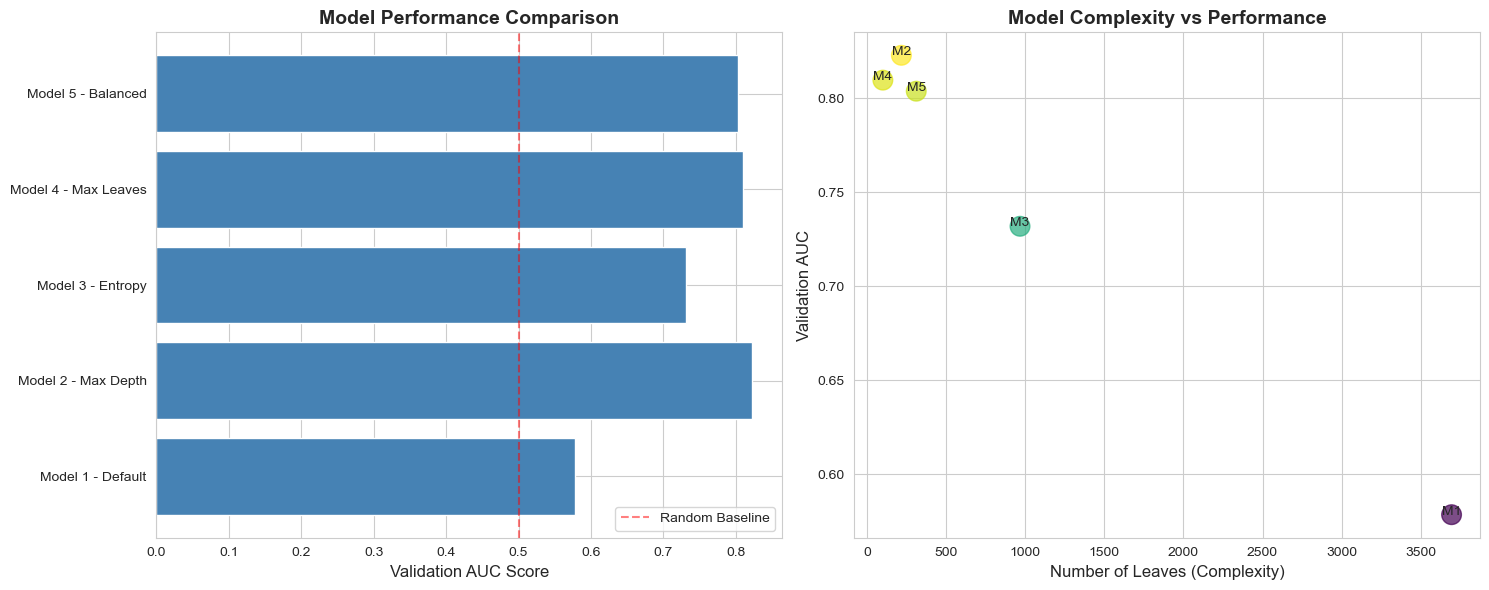

✓ Saved: model_comparison.png


In [15]:
# Visualize model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# AUC comparison
ax1.barh(results['Model'], results['Validation AUC'], color='steelblue')
ax1.set_xlabel('Validation AUC Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
ax1.legend()

# Complexity vs Performance
ax2.scatter(results['Number of Leaves'], results['Validation AUC'], 
           s=200, c=results['Validation AUC'], cmap='viridis', alpha=0.7)
ax2.set_xlabel('Number of Leaves (Complexity)', fontsize=12)
ax2.set_ylabel('Validation AUC', fontsize=12)
ax2.set_title('Model Complexity vs Performance', fontsize=14, fontweight='bold')
for idx, row in results.iterrows():
    ax2.annotate(f"M{idx+1}", (row['Number of Leaves'], row['Validation AUC']),
                fontsize=10, ha='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: model_comparison.png")

## 8. Visualize Best Model

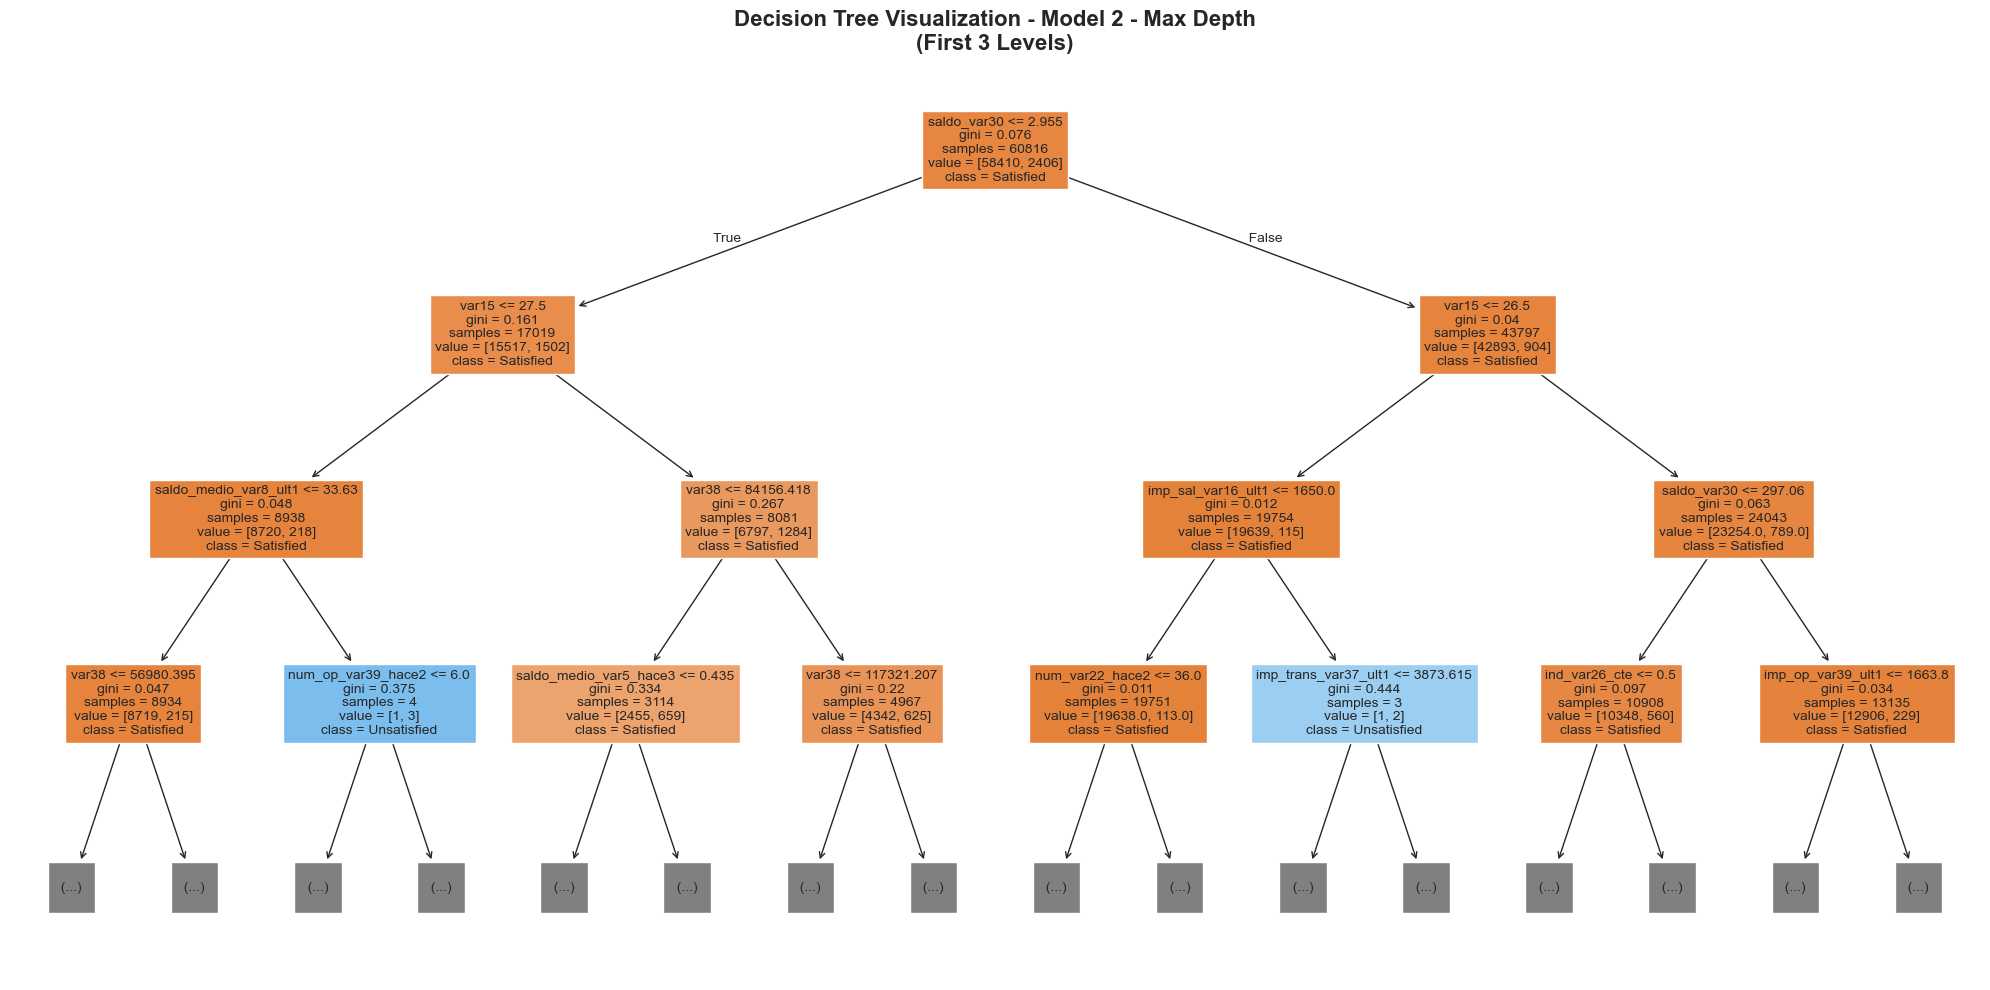

✓ Saved: best_tree_visualization.png


In [16]:
# Select best model
models = [model1, model2, model3, model4, model5]
best_model = models[best_idx]

# Visualize tree (simplified - first 3 levels)
plt.figure(figsize=(20, 10))
plot_tree(best_model, max_depth=3, feature_names=X.columns,
          class_names=['Satisfied', 'Unsatisfied'], filled=True, fontsize=10)
plt.title(f'Decision Tree Visualization - {best_model_name}\n(First 3 Levels)', 
         fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('best_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: best_tree_visualization.png")

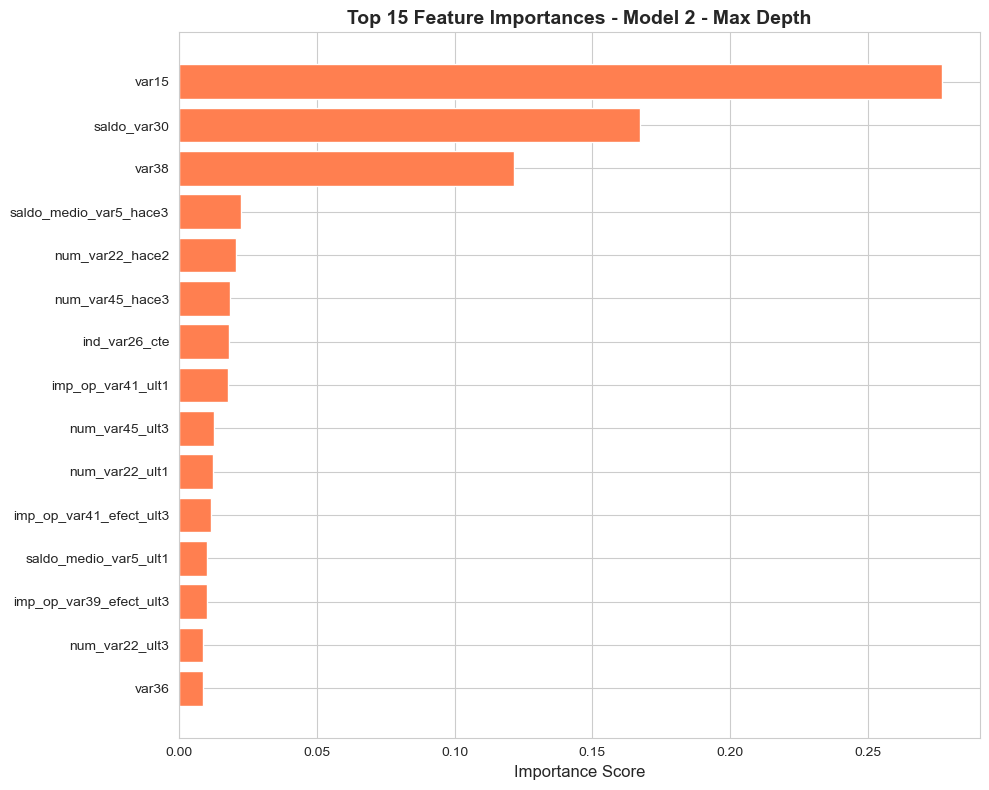

✓ Saved: feature_importance.png


In [17]:
# Feature importance from best model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='coral')
plt.xlabel('Importance Score', fontsize=12)
plt.title(f'Top 15 Feature Importances - {best_model_name}', 
         fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_importance.png")

## 9. Why This is a HARD Machine Learning Problem

In [18]:
print("=" * 80)
print("WHY THIS IS A HARD MACHINE LEARNING PROBLEM")
print("=" * 80)

print("\n1️⃣ SEVERE CLASS IMBALANCE (9/10 difficulty)")
print("-" * 80)
print(f"   • Only {train['TARGET'].mean()*100:.2f}% of customers are unsatisfied")
print(f"   • Imbalance ratio: {(1-train['TARGET'].mean())/train['TARGET'].mean():.0f}:1")
print("   ❌ Problem: Models naturally bias toward majority class")
print("   ❌ Can achieve 96% accuracy by always predicting 'satisfied'!")
print("   ❌ Standard evaluation metrics (accuracy) are misleading")

print("\n2️⃣ ANONYMIZED FEATURES (8/10 difficulty)")
print("-" * 80)
print(f"   • {len(feature_cols)} features, all named 'var1', 'var2', etc.")
print("   • No idea what they represent (age? income? balance?)")
print("   ❌ Problem: Cannot use domain knowledge")
print("   ❌ Cannot engineer meaningful features")
print("   ❌ Cannot validate if results make business sense")

print("\n3️⃣ HIGH DIMENSIONALITY (7/10 difficulty)")
print("-" * 80)
print(f"   • {len(feature_cols)} total features")
print(f"   • {len(constant_features)} constant (useless) features")
print(f"   • {len(low_variance_features)} low variance features")
print("   ❌ Problem: Curse of dimensionality")
print("   ❌ Many irrelevant features add noise")
print("   ❌ High risk of overfitting")

print("\n4️⃣ WEAK SIGNAL / NOISY DATA (8/10 difficulty)")
print("-" * 80)
max_corr = corr_df['abs_correlation'].max()
mean_corr = corr_df['abs_correlation'].mean()
print(f"   • Highest feature correlation with TARGET: {max_corr:.4f}")
print(f"   • Average correlation: {mean_corr:.4f}")
print("   ❌ Problem: Unsatisfied customers often don't complain")
print("   ❌ Some labeled 'satisfied' may actually be unhappy")
print("   ❌ Decision boundaries are fuzzy, not clear-cut")

print("\n" + "=" * 80)
print("CONCLUSION: This is a VERY DIFFICULT problem!")
print("=" * 80)
print("Simple models like single Decision Trees have limited success.")
print("Best solutions use ensemble methods (Random Forest, XGBoost) with")
print("careful feature engineering and class imbalance handling.")
print("=" * 80)

WHY THIS IS A HARD MACHINE LEARNING PROBLEM

1️⃣ SEVERE CLASS IMBALANCE (9/10 difficulty)
--------------------------------------------------------------------------------
   • Only 3.96% of customers are unsatisfied
   • Imbalance ratio: 24:1
   ❌ Problem: Models naturally bias toward majority class
   ❌ Can achieve 96% accuracy by always predicting 'satisfied'!
   ❌ Standard evaluation metrics (accuracy) are misleading

2️⃣ ANONYMIZED FEATURES (8/10 difficulty)
--------------------------------------------------------------------------------
   • 369 features, all named 'var1', 'var2', etc.
   • No idea what they represent (age? income? balance?)
   ❌ Problem: Cannot use domain knowledge
   ❌ Cannot engineer meaningful features
   ❌ Cannot validate if results make business sense

3️⃣ HIGH DIMENSIONALITY (7/10 difficulty)
--------------------------------------------------------------------------------
   • 369 total features
   • 34 constant (useless) features
   • 97 low variance featu